In [111]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from xgboost import XGBRegressor as XGBR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
import math
import shap
import joblib
import mlxtend
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [112]:
mdf = pd.read_pickle("df_coeff.pkl")
mdf = mdf.reset_index()
mdf=mdf.drop('index', axis=1)

In [113]:
fontdict1={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'arial'}
fontdict2={'fontsize': 12, 'fontweight': 'bold', 'fontstyle': 'oblique', 'color': 'b', 'fontfamily': 'arial'}

In [114]:
mdf= mdf[['GasTemp', 'GasRH', 'H2SConcentration', 'flowRate', 'H/C', 'pH','C', 'N/C', 'O',
            'S_Bet','PyrolisTemp', 'BiocharRH', 'particleSize','S_Weight', 'Col_d', 'Col_h', 'a', 'b', 'K', 'T']]
Features= mdf[['GasRH', 'H2SConcentration', 'flowRate','C', 'H/C', 'pH',
            'S_Bet','PyrolisTemp', 'BiocharRH', 'particleSize','S_Weight', 'Col_h']]
Target= mdf[['a', 'b', 'K', 'T']]
df=mdf[['GasRH', 'H2SConcentration', 'flowRate','C', 'H/C', 'pH',
            'S_Bet','PyrolisTemp', 'BiocharRH', 'particleSize','S_Weight', 'Col_h', 'a', 'b', 'K', 'T']]
df = df.rename(columns={'H2SConcentration': 'H2S'})
df = df.rename(columns={'PyrolisTemp': 'PTemp'})
df = df.rename(columns={'particleSize': 'PSize'})
df = df.rename(columns={'flowRate': 'FlowR'})
df = df.rename(columns={'BiocharRH': 'BRH'})
df = df.rename(columns={'S_Bet': 'SBet'})
df = df.rename(columns={'S_Weight': 'SW'})
df = df.rename(columns={'Col_h': 'ColH'})
#df['K']=1/df['K']

In [115]:
Results_df=df.copy().round(3)

In [116]:
Results_df.head(5)

,GasRH,H2S,FlowR,C,H/C,pH,SBet,PTemp,BRH,PSize,SW,ColH,a,b,K,T
0,0.0,50.0,40.0,22.2,0.356,5.25,2.10,100.0,0.0,0.825,1.0,150.0,4.193,29.056,10.494,25.184
1,0.0,50.0,40.0,22.2,0.356,5.40,6.40,200.0,0.0,0.825,1.0,150.0,6.924,134.811,28.651,123.304
2,0.0,50.0,40.0,22.2,0.356,6.00,11.30,300.0,0.0,0.825,1.0,150.0,9.623,149.749,21.947,140.847
3,0.0,50.0,40.0,22.2,0.356,9.50,20.35,400.0,0.0,0.825,1.0,150.0,17.551,513.425,42.379,494.556
4,0.0,50.0,40.0,22.2,0.356,9.00,22.60,500.0,0.0,0.825,1.0,150.0,8.284,268.698,48.022,249.229


In [117]:
from docx import Document
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.shared import Pt

doc = Document()
table = doc.add_table(Results_df.shape[0] + 1, Results_df.shape[1])
table.alignment = WD_ALIGN_PARAGRAPH.CENTER  # Center-align the table

# Set column widths (optional)
for cell in table.rows[0].cells:
    cell.width = Pt(100)  # Adjust the width as needed

# Add column headers
for i, column_name in enumerate(Results_df.columns):
    table.cell(0, i).text = column_name

# Add data to the table
for i in range(Results_df.shape[0]):
    for j in range(Results_df.shape[1]):
        table.cell(i + 1, j).text = str(Results_df.iloc[i, j])

# Save the document
doc.save('dataframe_table.docx')

KeyboardInterrupt: 

# Determining T

# XGBR

In [118]:

X= df[['GasRH', 'H2S', 'FlowR', 'C', 'H/C', 'pH', 'SBet', 'PTemp', 'BRH', 'PSize', 'SW', 'ColH']]
y=df['T']
#-------------------------------------------------------------------------------------------------------------

for rs in [71]:                   # 19 71 248
    print('Random State: ', rs)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = rs) # Split the data



# Train the model on the training set

    est=XGBR(learning_rate =0.012, n_estimators=300, reg_alpha=0.071, reg_lambda=0.040, max_depth =7, random_state =7)
    est.fit(X_train, y_train)

# Make predictions on the testing set
    y_pred_test = est.predict(X_test).round(2)
    y_pred_train = est.predict(X_train).round(2)
    
       
    r2_a_train = r2_score(y_train, y_pred_train)
    r2_a_test = r2_score(y_test,   y_pred_test)
    CV5_scores = cross_val_score(est, X_train, y_train, cv=5)

    print('train: R2 score for predicting b coeff = ', r2_a_train.round(3))
    print('test: R2 score for predicting b coeff = ', r2_a_test.round(3))
    print('cv5: R2 score for predicting b coeff = ', CV5_scores.mean().round(3))
    print('---')
    
    #---------------------------------------------------------------------------------------------------------------
joblib.dump(est, 'XGBR_G.sav')

Random State:  71
train: R2 score for predicting b coeff =  0.999
test: R2 score for predicting b coeff =  0.952
cv5: R2 score for predicting b coeff =  0.885
---


['XGBR_G.sav']

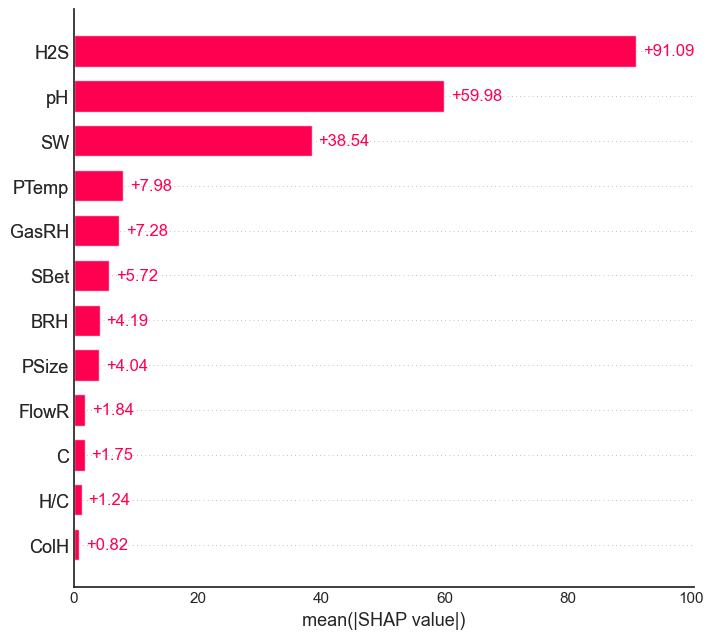

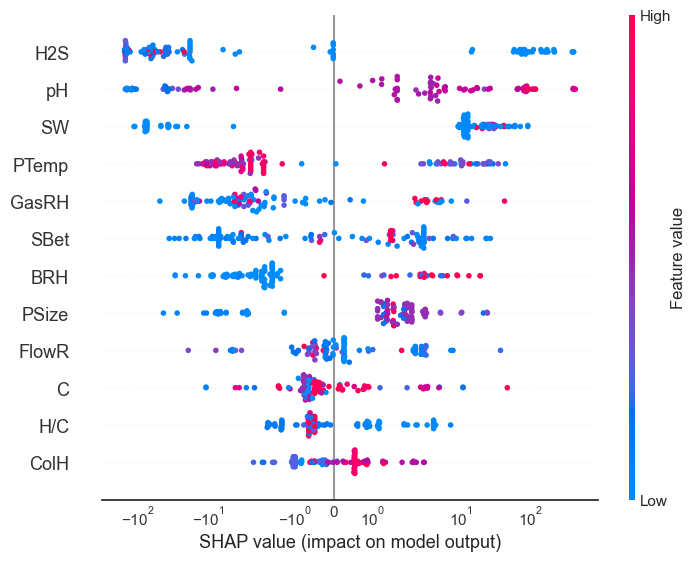

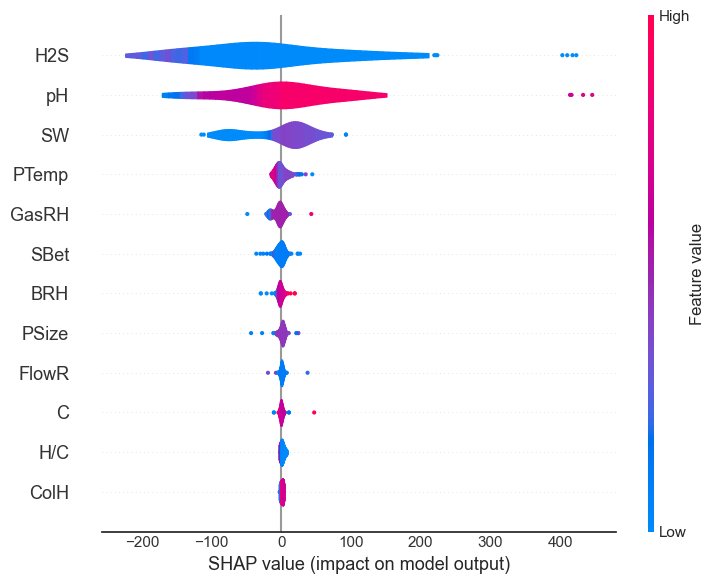

In [119]:
estimator = est
explainer = shap.Explainer(estimator, seed = 30, algorithm ='tree')
shap_values = explainer(X_train) 
ax=shap.plots.bar(shap_values, max_display=12, order=shap.Explanation.abs, show=True)
ax1=shap.plots.beeswarm(shap_values, max_display=12, log_scale=True)
ax2=shap.summary_plot(shap_values, X_train, plot_type="violin", color_bar_label='Feature value',layered_violin_max_num_bins=40)


# GBR

In [121]:

X= df[['GasRH', 'H2S', 'FlowR', 'C', 'H/C', 'pH', 'SBet', 'PTemp', 'BRH', 'PSize', 'SW', 'ColH']]
y=df['T']
#-------------------------------------------------------------------------------------------------------------

for rs in [71]:                   # 41,71
    print('Random State: ', rs)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = rs) # Split the data

# Train the model on the training set
    est=GBR(learning_rate=0.018, n_estimators=200, alpha=0.2, random_state=8, max_depth=7 )  
    est.fit(X_train, y_train)

# Make predictions on the testing set
    y_pred_test = est.predict(X_test).round(2)
    y_pred_train = est.predict(X_train).round(2)
    
       
    r2_a_train = r2_score(y_train, y_pred_train)
    r2_a_test = r2_score(y_test,   y_pred_test)
    CV5_scores = cross_val_score(est, X_train, y_train, cv=5)

    print('train: R2 score for predicting b coeff = ', r2_a_train.round(3))
    print('test: R2 score for predicting b coeff = ', r2_a_test.round(3))
    print('cv5: R2 score for predicting b coeff = ', CV5_scores.mean().round(3))
    print('---')
    
    #---------------------------------------------------------------------------------------------------------------
joblib.dump(est, 'GBR_G.sav')

Random State:  71
train: R2 score for predicting b coeff =  0.999
test: R2 score for predicting b coeff =  0.962
cv5: R2 score for predicting b coeff =  0.869
---


['GBR_G.sav']

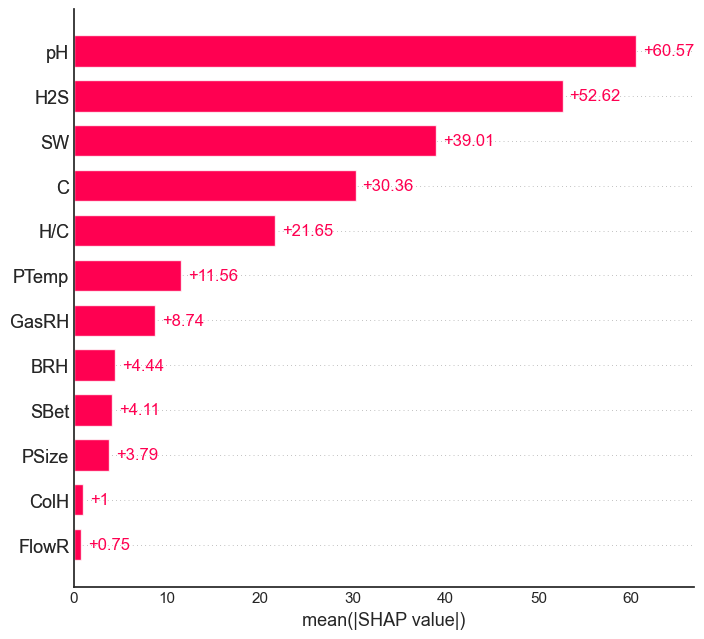

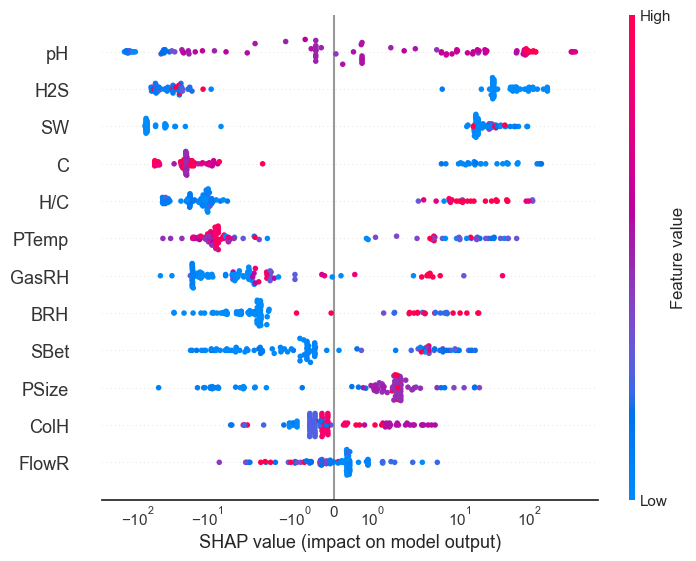

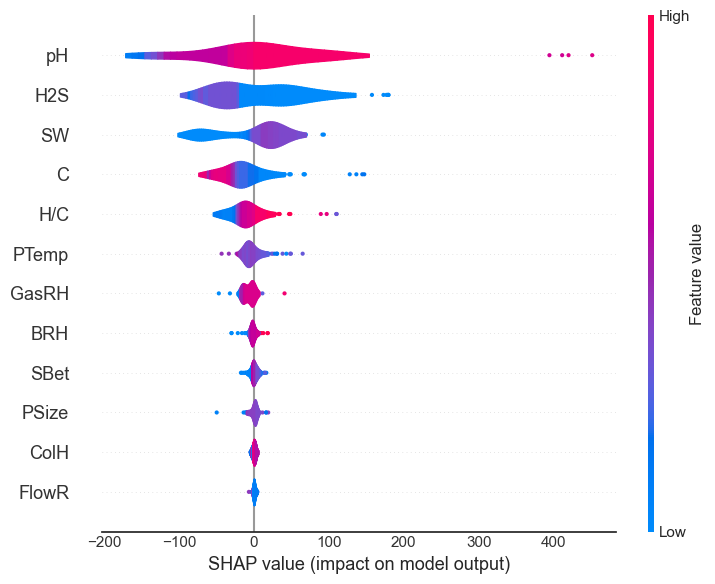

In [122]:
estimator = est
explainer = shap.Explainer(estimator, seed = 30, algorithm ='tree')
shap_values = explainer(X_train) 
ax=shap.plots.bar(shap_values, max_display=12, order=shap.Explanation.abs, show=True)
ax1=shap.plots.beeswarm(shap_values, max_display=12, log_scale=True)
ax2=shap.summary_plot(shap_values, X_train, plot_type="violin", color_bar_label='Feature value',layered_violin_max_num_bins=40)


# RFR

In [123]:

X= df[['GasRH', 'H2S', 'FlowR', 'C', 'H/C', 'pH', 'SBet', 'PTemp', 'BRH', 'PSize', 'SW', 'ColH']]
y=df['T']
#-------------------------------------------------------------------------------------------------------------

for rs in [71]:                   # ,201,248,3,13,43,48,71
    print('Random State: ', rs)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = rs) # Split the data

# Train the model on the training set

    est=RF(n_estimators=300, max_depth=8, min_samples_leaf=1,criterion='squared_error', random_state=3 )   
    est.fit(X_train, y_train)

# Make predictions on the testing set
    y_pred_test = est.predict(X_test).round(2)
    y_pred_train = est.predict(X_train).round(2)
    
       
    r2_a_train = r2_score(y_train, y_pred_train)
    r2_a_test = r2_score(y_test,   y_pred_test)
    CV5_scores = cross_val_score(est, X_train, y_train, cv=5)

    print('train: R2 score for predicting T coeff = ', r2_a_train.round(3))
    print('test: R2 score for predicting T coeff = ', r2_a_test.round(3))
    print('cv5: R2 score for predicting T coeff = ', CV5_scores.mean().round(3))
    print('---')
    
    #---------------------------------------------------------------------------------------------------------------
joblib.dump(est, 'RFR_G.sav')

Random State:  71
train: R2 score for predicting T coeff =  0.979
test: R2 score for predicting T coeff =  0.842
cv5: R2 score for predicting T coeff =  0.819
---


['RFR_G.sav']

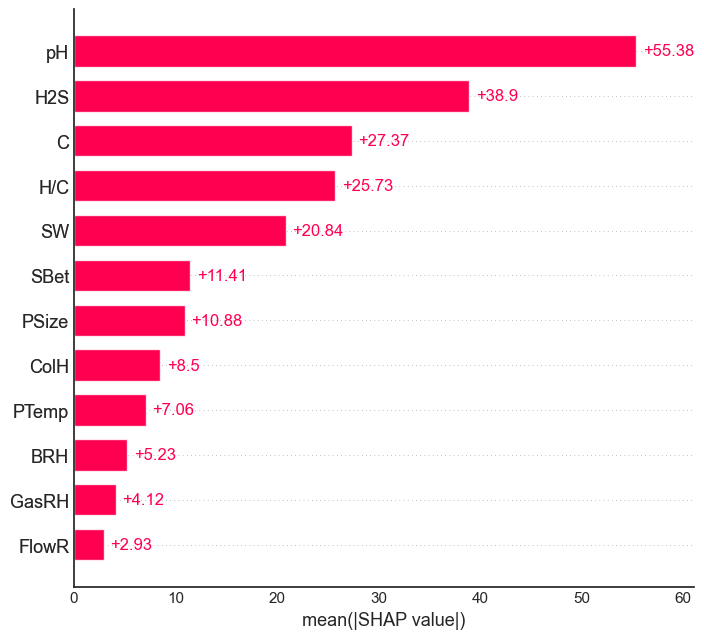

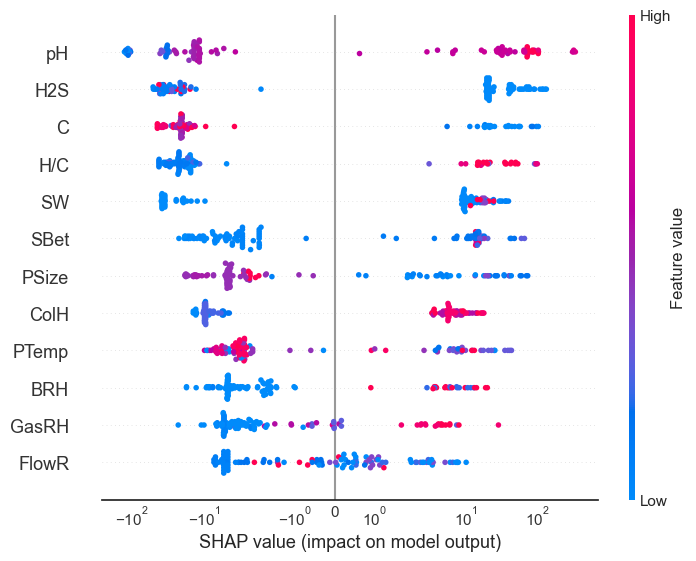

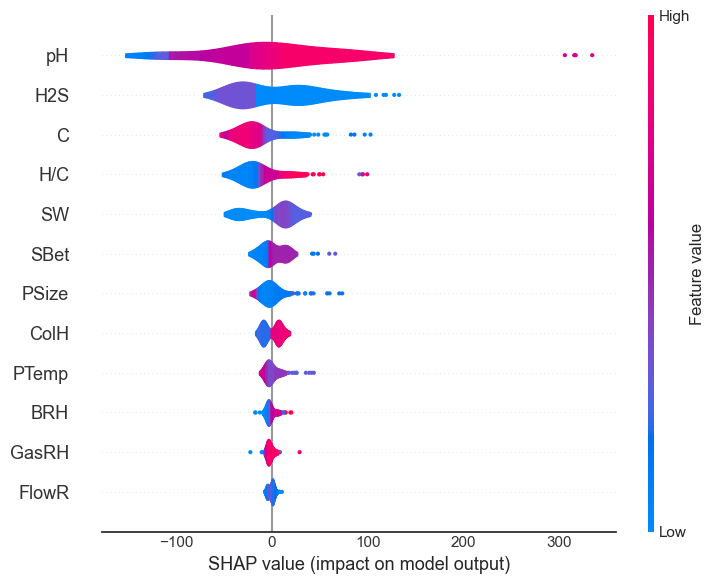

In [124]:
estimator = est
explainer = shap.Explainer(estimator, seed = 30, algorithm ='tree')
shap_values = explainer(X_train) 
ax=shap.plots.bar(shap_values, max_display=12, order=shap.Explanation.abs, show=True)
ax1=shap.plots.beeswarm(shap_values, max_display=12, log_scale=True)
ax2=shap.summary_plot(shap_values, X_train, plot_type="violin", color_bar_label='Feature value',layered_violin_max_num_bins=40)


In [125]:
XGBR_M=joblib.load('XGBR_G.sav')
GBR_M= joblib.load('GBR_G.sav')
RFR_M= joblib.load('RFR_G.sav')

# ploting accuracy

In [126]:
plt.style.use('seaborn-white')
# Set the default text font size
plt.rc('font', size=22)
# Set the fig title font size
plt.rc('axes', titlesize=22)
# Set the axes labels font size
plt.rc('axes', labelsize=2)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=20)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=20)
# Set the legend font size
plt.rc('legend', fontsize=22)
# Set the font size of the figure title
plt.rc('figure', titlesize=22)

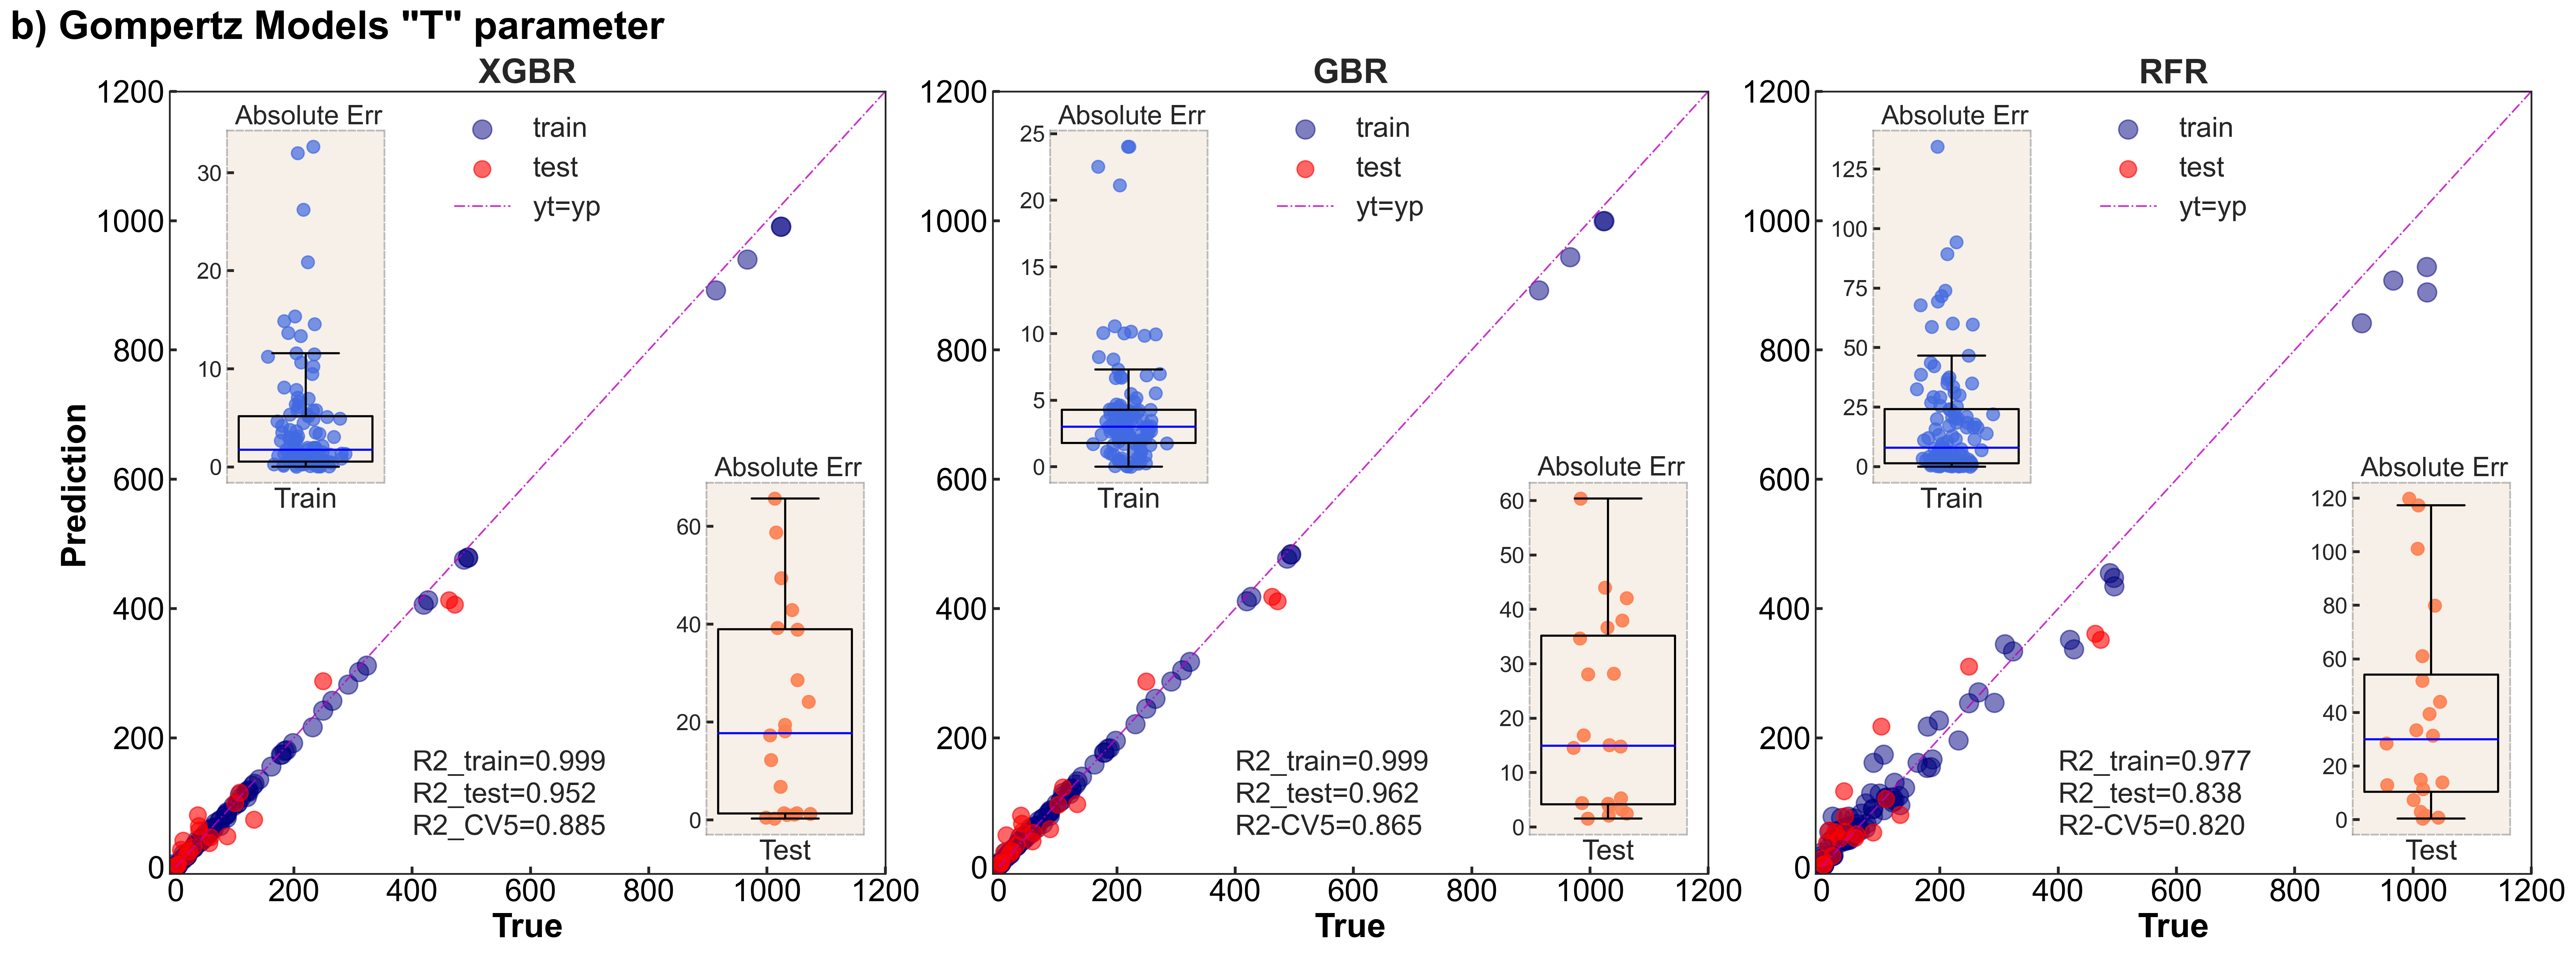

In [127]:
import matplotlib.gridspec as gridspec
 
fontdict1={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'arial'}
fontdict2={'fontsize': 24, 'fontweight': 'bold', 'color': 'k', 'fontfamily': 'arial'}
rs=[71,71,71]
XGBR_M=joblib.load('XGBR_G.sav')
GBR_M= joblib.load('GBR_G.sav')
RFR_M= joblib.load('RFR_G.sav')

yp_train_XGBR= XGBR_M.predict(X_train)
yp_train_GBR= GBR_M.predict(X_train)
yp_train_RFR= RFR_M.predict(X_train)

yp_test_XGBR= XGBR_M.predict(X_train)
yp_test_GBR= GBR_M.predict(X_train)
yp_test_RFR= RFR_M.predict(X_train)

fig = plt.figure(figsize=(30,10), dpi=300)
gs  = gridspec.GridSpec(1, 3, wspace=0.15, hspace=0.1, width_ratios=[1, 1, 1], height_ratios=[1])
modelsName=['XGBR', 'GBR', 'RFR']

YP_train=[yp_train_XGBR,yp_train_GBR,yp_train_RFR]

j=0
for i in range(0,3):
    ax = fig.add_subplot(gs[0,j])
    #------------------------------------------------ Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = rs[i])
    yp_train_XGBR= XGBR_M.predict(X_train)
    yp_train_GBR= GBR_M.predict(X_train)
    yp_train_RFR= RFR_M.predict(X_train)

    yp_test_XGBR= XGBR_M.predict(X_test)
    yp_test_GBR= GBR_M.predict(X_test)
    yp_test_RFR= RFR_M.predict(X_test)
    YP_train=[yp_train_XGBR, yp_train_GBR, yp_train_RFR]
    YP_test=[yp_test_XGBR, yp_test_GBR, yp_test_RFR]
    
    ax.scatter(y_train, YP_train[i], s=180, color='navy',label='train', alpha=0.5)
    ax.scatter(y_test, YP_test[i], s=140, color='r',label='test', alpha=0.6)
    ax.plot([0, 1200], [0, 1200], 'k-.', lw=1.2, label='yt=yp', alpha=.8, color='m')

    #-----------------------------------------------------------------------------------
    ax2=ax.inset_axes([0.08, .50, 0.22, 0.45])
    ax2.set_xticks([])
    ax2.tick_params(axis='y', labelsize=16)
    ax2.spines[['top', 'bottom','right', 'left' ]].set_color('gray')
    ax2.spines[['top', 'bottom','right', 'left' ]].set_linestyle('--')
    ax2.spines[['top', 'bottom','right', 'left' ]].set_alpha(0.5)
    ax2.set_facecolor('tan')
    ax2.patch.set_alpha(0.2)
    #--------------------------------------------
    # calculate the train eroors
    err_train=abs(y_train-YP_train[i]).round(3)
    #--------------------------------------------
    ax2.boxplot(err_train, widths=0.85,labels=['Train'], meanline =True,vert=True,
                showfliers = False,
                medianprops = {"color": "b", "linewidth": 1.5},
                boxprops = {"color": "k", "linewidth": 1.5},
                whiskerprops = {"color": "k", "linewidth": 1.5},
                capprops = {"color": "k", "linewidth": 1.5})
    xs, names = [], []
    vals=np.asanyarray(err_train)
    #names.append(col)
    xs.append(np.random.normal(1, 0.1, len(err_train)))
    ax2.scatter(xs,err_train, alpha= 0.7, marker='o', s=80, color='royalblue')
    ax2.text(0.55, 1.07*max(err_train), 'Absolute Err', fontsize = 19)
    #-----------------------------------------------------------------------------------------
    #-----------------------------------------------------------------------------------------
    ax3=ax.inset_axes([0.75, .05, 0.22, 0.45])
    ax3.tick_params(axis='y', labelsize=16)
    ax3.set_xticks([])
    ax3.spines[['top', 'bottom','right', 'left' ]].set_color('gray')
    ax3.spines[['top', 'bottom','right', 'left' ]].set_linestyle('--')
    ax3.spines[['top', 'bottom','right', 'left' ]].set_alpha(0.5)
    ax3.set_facecolor('tan')
    ax3.patch.set_alpha(0.2)
    #--------------------------------------------
    # calculate the train eroors
    err_test=abs(y_test-YP_test[i]).round(3)
    #--------------------------------------------
    ax3.boxplot(err_test, widths=0.85,labels=['Test'], meanline =True,vert=True,
                showfliers = False,
                medianprops = {"color": "b", "linewidth": 1.5},
                boxprops = {"color": "k", "linewidth": 1.5},
                whiskerprops = {"color": "k", "linewidth": 1.5},
                capprops = {"color": "k", "linewidth": 1.5})
    xs, names = [], []
    vals=np.asanyarray(err_train)
    #names.append(col)
    xs.append(np.random.normal(1, 0.1, len(err_test)))
    ax3.scatter(xs,err_test, alpha= 0.9, marker='o', s=80, color='coral')
    ax3.text(0.55, 1.07*max(err_test), 'Absolute Err', fontsize = 19)
    #------------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------------

    ax.set_xlim([-10, 1200])
    ax.set_ylim([-10, 1200])
    ax.set_xlabel('True', fontdict=fontdict2)
    if j==0:
        ax.set_ylabel('Prediction', fontdict=fontdict2)
    ax.set_title(modelsName[j]  , loc= 'center', fontdict = fontdict1, fontsize=24)
    ax.tick_params(labelcolor='k', labelsize='medium', width=3)
    ax.legend(loc= 'upper center', fontsize=20)
    ax.tick_params(axis='x', which='both', direction='in', length=5, width=2)
    ax.tick_params(axis='y', which='both', direction='in', length=5, width=2)
    ax2.tick_params(axis='y', which='both', direction='in', length=5, width=2)
    ax3.tick_params(axis='y', which='both', direction='in', length=5, width=2)
    #------------------------------------------------------------------------------------------
    R2TR=['R2_train=0.999','R2_train=0.999','R2_train=0.977']
    R2TE=['R2_test=0.952','R2_test=0.962','R2_test=0.838']
    CV5R2=['R2_CV5=0.885','R2-CV5=0.865','R2-CV5=0.820']
    ax.text(400, 150, R2TR[j], fontsize = 20)
    ax.text(400, 100,  R2TE[j], fontsize = 20)
    ax.text(400, 50,  CV5R2[j], fontsize = 20)
    j=j+1
fig.suptitle('b) Gompertz Models "T" parameter', fontsize=28, fontweight='bold', color='k', x=.18, y=0.96)
plt.savefig('G_b_errors', dpi=300)
plt.show()

In [128]:
T_xgbr=XGBR_M.predict(X)
T_gbr=GBR_M.predict(X)
T_rfr=RFR_M.predict(X)

In [129]:
Results_df=df.copy()
Results_df['T_xgbr']=0
Results_df['T_gbr']=0
Results_df['T_rfr']=0
for i in range(0, len(Results_df)):
    Results_df['T_xgbr'].iloc[i]=float(T_xgbr[i].round(3))
    Results_df['T_gbr'].iloc[i]=float(T_gbr[i].round(3))
    Results_df['T_rfr'].iloc[i]=float(T_rfr[i].round(3))

Results_df.head(5)    

,GasRH,H2S,FlowR,C,H/C,pH,SBet,PTemp,BRH,PSize,SW,ColH,a,b,K,T,T_xgbr,T_gbr,T_rfr
0,0.0,50.0,40.0,22.2,0.355856,5.25,2.10,100.0,0.0,0.825,1.0,150.0,4.193433,29.056448,10.494361,25.183979,26.285999,29.279,55.128
1,0.0,50.0,40.0,22.2,0.355856,5.40,6.40,200.0,0.0,0.825,1.0,150.0,6.924287,134.811274,28.650561,123.303715,116.674004,120.113,102.863
2,0.0,50.0,40.0,22.2,0.355856,6.00,11.30,300.0,0.0,0.825,1.0,150.0,9.622541,149.748901,21.947262,140.847082,135.927994,140.203,123.105
3,0.0,50.0,40.0,22.2,0.355856,9.50,20.35,400.0,0.0,0.825,1.0,150.0,17.551036,513.425181,42.378810,494.556257,479.218994,484.514,434.773
4,0.0,50.0,40.0,22.2,0.355856,9.00,22.60,500.0,0.0,0.825,1.0,150.0,8.284210,268.698344,48.022293,249.228841,288.127014,287.227,310.366


# Finding k

In [130]:
def dose_response(t, a, b):
    return (1-1/(1+(t/b)**(a)))

def Gompertz(t, K, T):
    return (np.exp(-1*np.exp((1/K)*(T-t))))

Optimized parameters: [0.13181398 1.05410606]


Text(1.0237886783641412, 103.48352213412319, 'R2: 0.768')

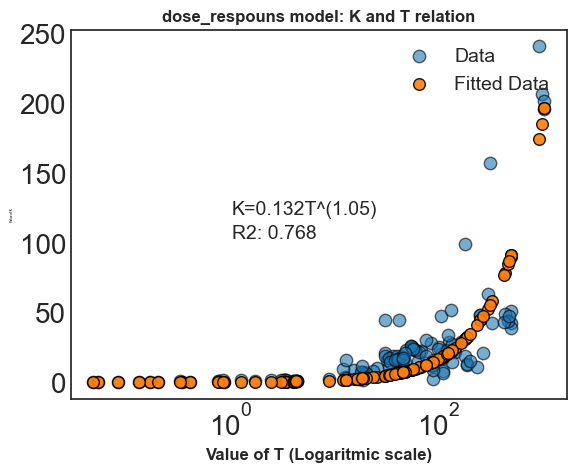

In [103]:
# Define the model function to fit
def model_func(x, c_1, c_2):
    return c_1*(x**c_2)
xx=np.asanyarray(df['T'])
yy=np.asanyarray(df['K'])
# Perform curve fitting

popt, pcov = curve_fit(model_func, xx, yy, method='lm', p0=[1.66,-0.9])
equation='K={:.3}T^({:.3})'.format(popt[0], popt[1])

# Print the optimized parameters
print('Optimized parameters:', popt)

plt.scatter(xx, yy, label='Data', marker='o', alpha=0.6, edgecolors='k', s=80)
plt.scatter(xx, np.asanyarray((model_func(xx, *popt))), label='Fitted Data', marker='o', alpha=0.9, edgecolors='k', s=70)
plt.xscale('log')
plt.legend(loc='upper right', fontsize=14)
plt.xlabel("Value of T (Logaritmic scale)", fontdict=fontdict1)
plt.ylabel("Value of K", fontweight='bold')
plt.title('dose_respouns model: K and T relation', fontdict=fontdict1)
R2_score= r2_score(yy, model_func(xx, *popt))
plt.text(xx.max()*0.001, yy.max()*0.5,equation,fontsize=14 )
plt.text(xx.max()*0.001, yy.max()*0.43,'R2: ' + str(R2_score.round(3)), fontsize=14)


In [137]:

X= df[['GasRH', 'H2S', 'FlowR', 'C', 'H/C', 'pH', 'SBet', 'PTemp',  'PSize', 'SW',  'T']]

y=df['K']


#-------------------------------------------------------------------------------------------------------------

for rs in [71]:                   # 64
    print('Random State: ', rs)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = rs) # Split the data

# Train the model on the training set
#    est=GBR(learning_rate=0.0235, n_estimators=260, alpha=0.1, random_state=10, max_depth=5 )
    est=XGBR(learning_rate =0.015, n_estimators=250, reg_alpha=0.060, reg_lambda=0.07, max_depth =5, random_state =7)
#    est=RF(n_estimators=600, max_depth=5, min_samples_leaf=2,criterion='squared_error', random_state=14 )
#    est = KNN(n_neighbors=5, leaf_size=20)
#    est=MLPRegressor(hidden_layer_sizes=(300, 30), activation='relu', solver='adam', max_iter=5000, random_state=0)
    
    est.fit(X_train, y_train)

# Make predictions on the testing set
    y_pred_test = est.predict(X_test).round(2)
    y_pred_train = est.predict(X_train).round(2)
          
    r2_a_train = r2_score(y_train, y_pred_train)
    r2_a_test = r2_score(y_test,   y_pred_test)
    CV5_scores = cross_val_score(est, X_train, y_train, cv=5)

    print('train: R2 score for predicting a coeff = ', r2_a_train.round(3))
    print('test: R2 score for predicting a coeff = ', r2_a_test.round(3))
    print('cv5: R2 score for predicting a coeff = ', CV5_scores.mean().round(3))
    print('---')
    
    #---------------------------------------------------------------------------------------------------------------
joblib.dump(est, 'RFR_K_G.sav')

Random State:  71
train: R2 score for predicting a coeff =  0.997
test: R2 score for predicting a coeff =  0.861
cv5: R2 score for predicting a coeff =  0.828
---


['RFR_K_G.sav']

In [82]:
y

0      10.494380
1      28.650559
2      21.947255
3      42.378825
4      48.022266
         ...    
125     0.098303
126    16.203785
127    15.946365
128    17.388163
129    33.897571
Name: K, Length: 130, dtype: float64

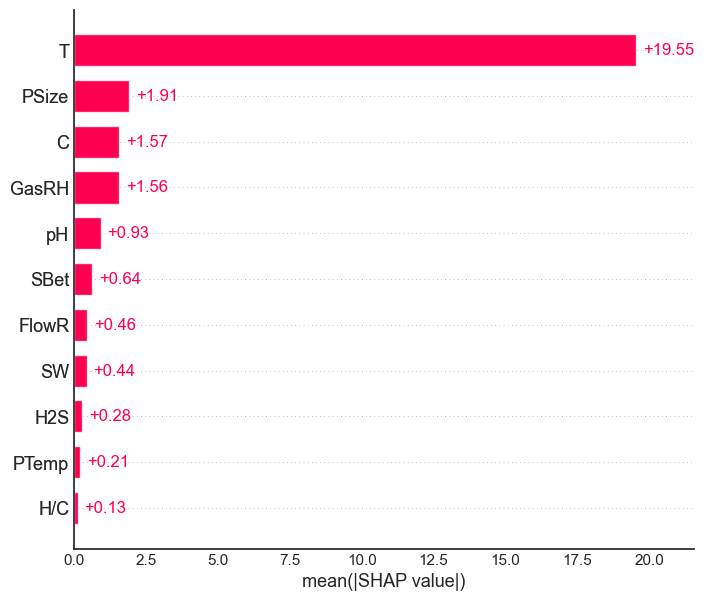

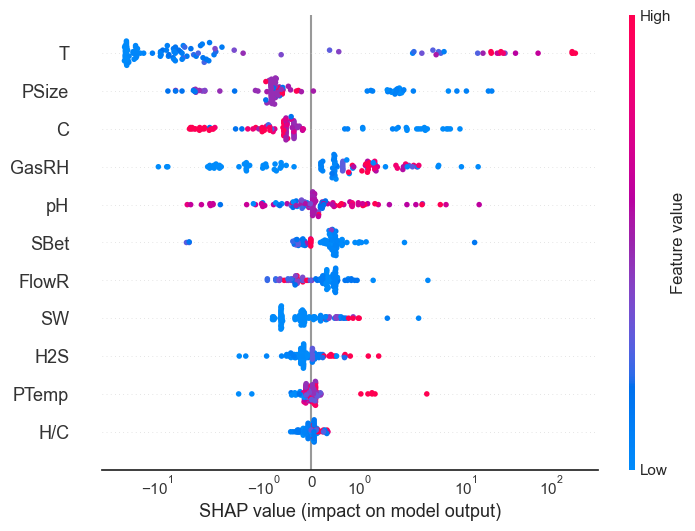

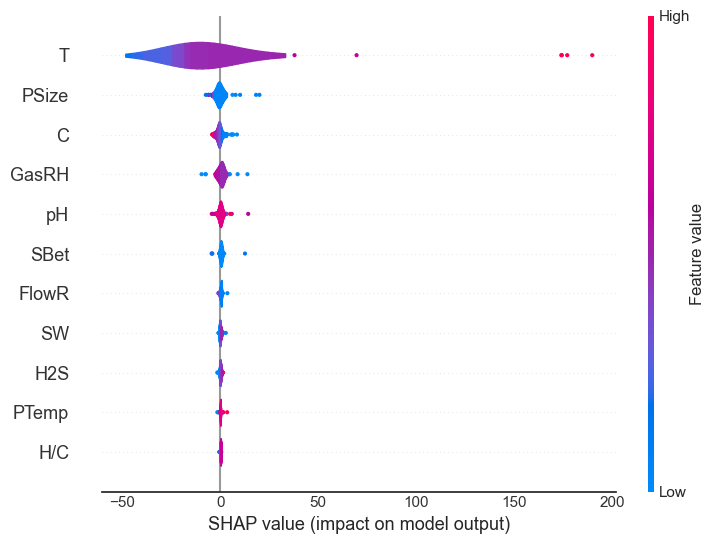

In [132]:
estimator = est
explainer = shap.Explainer(estimator, seed = 30, algorithm ='tree')
shap_values = explainer(X_train) 
ax=shap.plots.bar(shap_values, max_display=12, order=shap.Explanation.abs, show=True)
ax1=shap.plots.beeswarm(shap_values, max_display=12, log_scale=True)
ax2=shap.summary_plot(shap_values, X_train, plot_type="violin", color_bar_label='Feature value',layered_violin_max_num_bins=40)


In [133]:
RFR_K_G=joblib.load('RFR_K_G.sav')
K_pred=RFR_K_G.predict(X)

Results_df['K_pred']=0
for i in range(0, len(Results_df)):
    Results_df['K_pred'].iloc[i]=float(K_pred[i].round(3))

In [134]:
Results_df['K_pred_teor']=0
for i in range(0, len(Results_df)):
    Results_df['K_pred_teor'].iloc[i]= 0.132*(Results_df['T'].iloc[i])**1.05

In [135]:
Results_df.head(10)

,GasRH,H2S,FlowR,C,H/C,pH,SBet,PTemp,BRH,PSize,...,ColH,a,b,K,T,T_xgbr,T_gbr,T_rfr,K_pred,K_pred_teor
0,0.0,50.0,40.0,22.2,0.355856,5.25,2.10,100.0,0.0,0.825,...,150.0,4.193433,29.056448,10.494361,25.183979,26.285999,29.279,55.128,8.821000,3.906200
1,0.0,50.0,40.0,22.2,0.355856,5.40,6.40,200.0,0.0,0.825,...,150.0,6.924287,134.811274,28.650561,123.303715,116.674004,120.113,102.863,26.811001,20.706128
2,0.0,50.0,40.0,22.2,0.355856,6.00,11.30,300.0,0.0,0.825,...,150.0,9.622541,149.748901,21.947262,140.847082,135.927994,140.203,123.105,21.170000,23.809988
3,0.0,50.0,40.0,22.2,0.355856,9.50,20.35,400.0,0.0,0.825,...,150.0,17.551036,513.425181,42.378810,494.556257,479.218994,484.514,434.773,42.563000,89.022629
4,0.0,50.0,40.0,22.2,0.355856,9.00,22.60,500.0,0.0,0.825,...,150.0,8.284210,268.698344,48.022293,249.228841,288.127014,287.227,310.366,30.948999,43.351302
5,0.0,50.0,40.0,22.2,0.355856,5.40,2.10,100.0,0.0,0.350,...,150.0,4.653596,44.383042,13.983176,39.326325,63.497002,67.501,78.758,17.746000,6.237226
6,0.0,50.0,40.0,22.2,0.355856,5.70,6.40,200.0,0.0,0.350,...,150.0,4.906638,75.506096,22.316713,67.146779,68.267998,71.455,82.956,20.615999,10.938314
7,0.0,50.0,40.0,22.2,0.355856,6.45,11.30,300.0,0.0,0.350,...,150.0,9.774369,115.878162,17.116145,108.684966,115.492996,123.528,105.719,21.181999,18.136433
8,0.0,50.0,40.0,22.2,0.355856,9.75,17.10,400.0,0.0,0.350,...,150.0,14.049275,508.990247,51.360498,487.361326,475.773987,477.510,454.863,48.785999,87.663246
9,0.0,50.0,40.0,22.2,0.355856,8.50,22.60,500.0,0.0,0.350,...,150.0,7.408021,317.826771,63.154642,291.911004,282.437012,287.227,254.342,60.380001,51.178426


In [136]:
Results_df.to_pickle('Results_df.pkl')

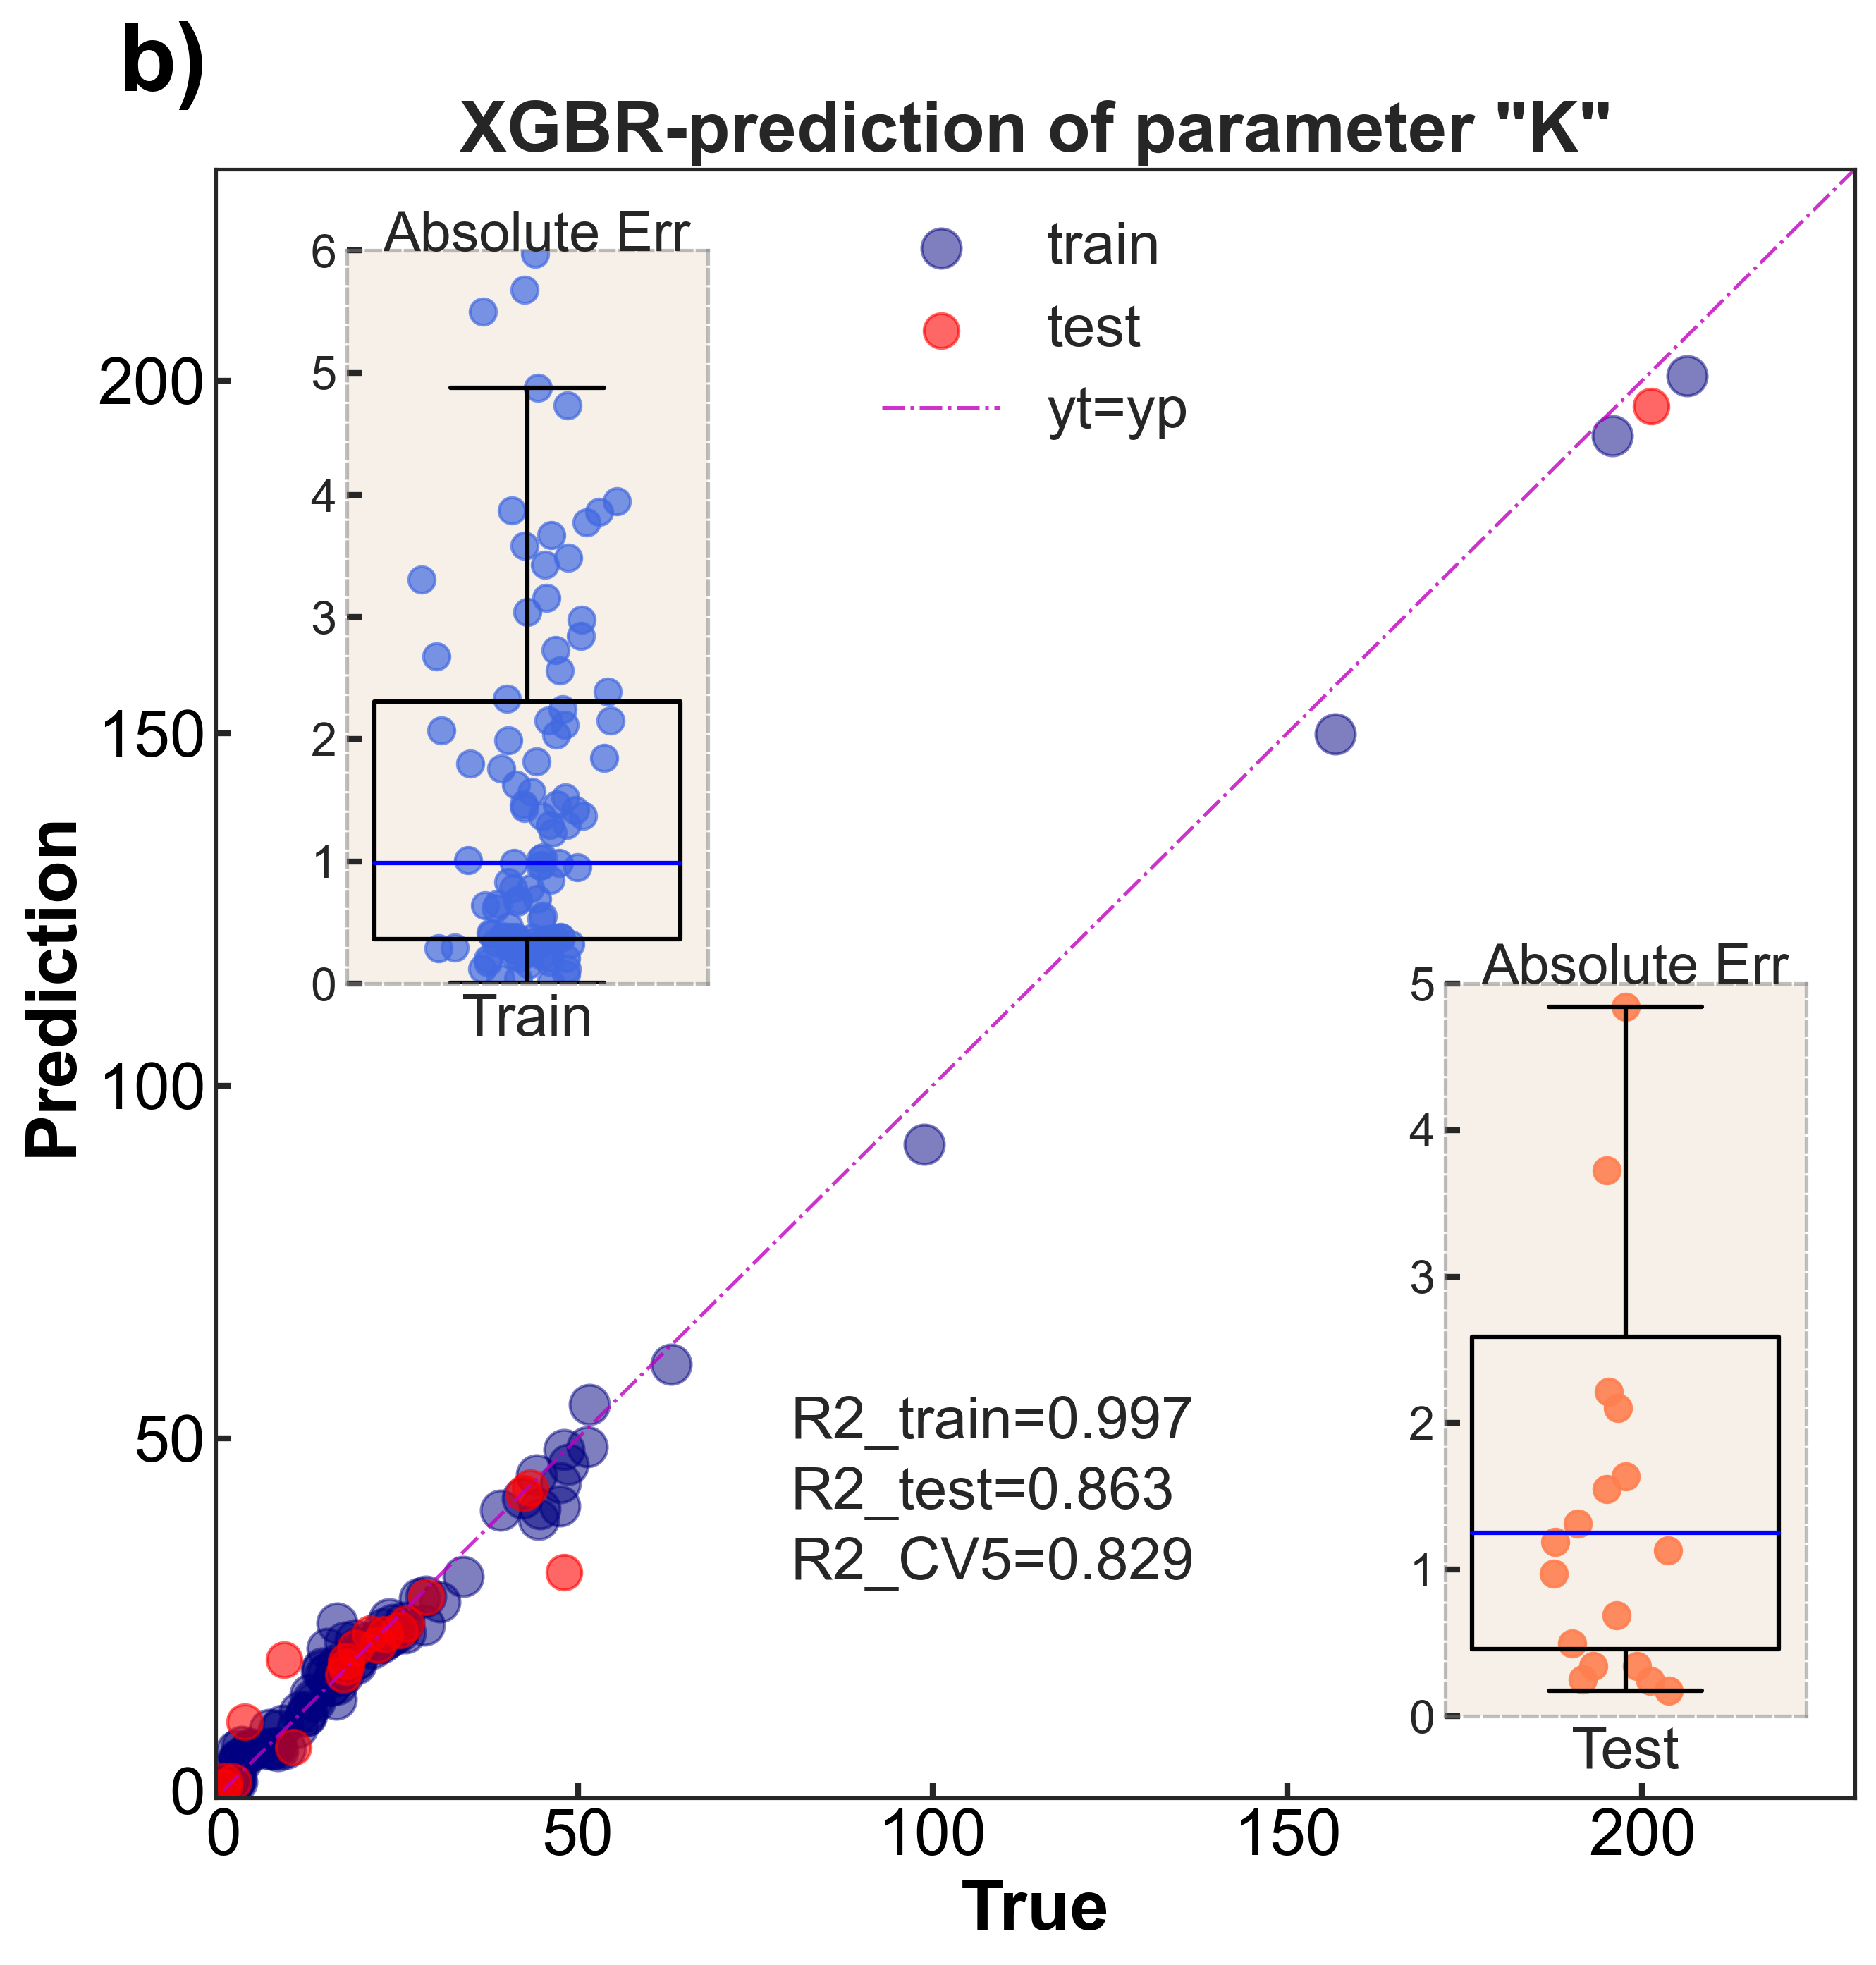

In [110]:
import matplotlib.gridspec as gridspec
 
fontdict1={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'arial'}
fontdict2={'fontsize': 24, 'fontweight': 'bold', 'color': 'k', 'fontfamily': 'arial'}
rs=[60]

RFR= joblib.load('RFR_K_G.sav')


yp_train_RFR= RFR.predict(X_train)
yp_test_RFR= RFR.predict(X_test)

fig = plt.figure(figsize=(10,10), dpi=300)
gs  = gridspec.GridSpec(1, 1, wspace=0.15, hspace=0.1, width_ratios=[1], height_ratios=[1])
modelsName=['XGBR-prediction of parameter "K"']

YP_train=[yp_train_RFR]

j=0
for i in range(0,1):
    ax = fig.add_subplot(gs[0,j])
    #------------------------------------------------ Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = rs[i])

    yp_train_RFR= RFR.predict(X_train)
    yp_test_RFR= RFR.predict(X_test)
    YP_train=[yp_train_RFR]
    YP_test=[yp_test_RFR]
    
    ax.scatter(y_train, YP_train[i], s=180, color='navy',label='train', alpha=0.5)
    ax.scatter(y_test, YP_test[i], s=140, color='r',label='test', alpha=0.6)
    ax.plot([0, 230], [0, 230], 'k-.', lw=1.2, label='yt=yp', alpha=.8, color='m')

    #-----------------------------------------------------------------------------------
    ax2=ax.inset_axes([0.08, .50, 0.22, 0.45])
    ax2.set_xticks([])
    ax2.tick_params(axis='y', labelsize=16)
    ax2.spines[['top', 'bottom','right', 'left' ]].set_color('gray')
    ax2.spines[['top', 'bottom','right', 'left' ]].set_linestyle('--')
    ax2.spines[['top', 'bottom','right', 'left' ]].set_alpha(0.5)
    ax2.set_facecolor('tan')
    ax2.patch.set_alpha(0.2)
    #--------------------------------------------
    # calculate the train eroors
    err_train=abs(y_train-YP_train[i]).round(3)
    #--------------------------------------------
    ax2.boxplot(err_train, widths=0.85,labels=['Train'], meanline =True,vert=True,
                showfliers = False,
                medianprops = {"color": "b", "linewidth": 1.5},
                boxprops = {"color": "k", "linewidth": 1.5},
                whiskerprops = {"color": "k", "linewidth": 1.5},
                capprops = {"color": "k", "linewidth": 1.5})
    xs, names = [], []
    vals=np.asanyarray(err_train)
    #names.append(col)
    xs.append(np.random.normal(1, 0.1, len(err_train)))
    ax2.scatter(xs,err_train, alpha= 0.7, marker='o', s=80, color='royalblue')
    ax2.text(0.6, 6, 'Absolute Err', fontsize = 19)
    ax2.set_ylim([0, 6])
    #-----------------------------------------------------------------------------------------
    #-----------------------------------------------------------------------------------------
    ax3=ax.inset_axes([0.75, .05, 0.22, 0.45])
    ax3.tick_params(axis='y', labelsize=16)
    ax3.set_xticks([])
    ax3.spines[['top', 'bottom','right', 'left' ]].set_color('gray')
    ax3.spines[['top', 'bottom','right', 'left' ]].set_linestyle('--')
    ax3.spines[['top', 'bottom','right', 'left' ]].set_alpha(0.5)
    ax3.set_facecolor('tan')
    ax3.patch.set_alpha(0.2)
    #--------------------------------------------
    # calculate the train eroors
    err_test=abs(y_test-YP_test[i]).round(3)
    #--------------------------------------------
    ax3.boxplot(err_test, widths=0.85,labels=['Test'], meanline =True,vert=True,
                showfliers = False,
                medianprops = {"color": "b", "linewidth": 1.5},
                boxprops = {"color": "k", "linewidth": 1.5},
                whiskerprops = {"color": "k", "linewidth": 1.5},
                capprops = {"color": "k", "linewidth": 1.5})
    xs, names = [], []
    vals=np.asanyarray(err_train)
    #names.append(col)
    xs.append(np.random.normal(1, 0.1, len(err_test)))
    ax3.scatter(xs,err_test, alpha= 0.9, marker='o', s=80, color='coral')
    ax3.text(0.6, 5, 'Absolute Err', fontsize = 19)
    ax3.set_ylim([0, 5])
    
    #------------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------------

    ax.set_xlim([-1, 230])
    ax.set_ylim([-1, 230])
    ax.set_xlabel('True', fontdict=fontdict2)
    if j==0:
        ax.set_ylabel('Prediction', fontdict=fontdict2)
    ax.set_title(modelsName[j]  , loc= 'center', fontdict = fontdict1, fontsize=24)
    ax.tick_params(labelcolor='k', labelsize='medium', width=3)
    ax.legend(loc= 'upper center', fontsize=20)
    ax.tick_params(axis='x', which='both', direction='in', length=5, width=2)
    ax.tick_params(axis='y', which='both', direction='in', length=5, width=2)
    ax2.tick_params(axis='y', which='both', direction='in', length=5, width=2)
    ax3.tick_params(axis='y', which='both', direction='in', length=5, width=2)
    #------------------------------------------------------------------------------------------

    ax.text(80, 50, 'R2_train=0.997', fontsize = 20)
    ax.text(80, 40,  'R2_test=0.863', fontsize = 20)
    ax.text(80, 30,  'R2_CV5=0.829', fontsize = 20)
    j=j+1
fig.suptitle('b)', fontsize=32, fontweight='bold', color='k', x=.1, y=0.95)
plt.savefig('dr_k_errors', dpi=300)
plt.show()